# Test One for the Classical SRNN

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from ClassicalModels.ClassicalSRNNs import ClassicalSRNN
from ClassicalModels.ClassicalSRNNs import SuportFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test One

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='HenonMapTest1.csv'

#### Read the data

In [6]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [7]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 1000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.02825174685561237, 0.08827631523818379]
----------------------------------------


#### Generate the data iter

In [8]:
testSetRatio=0.2
numStep=5
batchSize=4

In [9]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [10]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Train Data Size: 156
X= tensor([[-0.3667,  1.1110, -0.8381,  0.3500,  0.5771],
        [ 0.8393,  0.1588,  1.2165, -1.0241, -0.1033],
        [ 0.3385,  1.0580, -0.4657,  1.0138, -0.5787],
        [-0.5344,  0.8991, -0.2921,  1.1503, -0.9400]])
Y= tensor([[ 1.1110, -0.8381,  0.3500,  0.5771,  0.6387],
        [ 0.1588,  1.2165, -1.0241, -0.1033,  0.6779],
        [ 1.0580, -0.4657,  1.0138, -0.5787,  0.8353],
        [ 0.8991, -0.2921,  1.1503, -0.9400,  0.1079]])


In [11]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Test Data Size: 36
X= tensor([[ 0.4958,  0.8650,  0.1012,  1.2451, -1.1402],
        [-0.7807,  0.4913,  0.4279,  0.8911,  0.0168],
        [ 1.1060, -0.6214,  0.7912, -0.0627,  1.2318],
        [ 0.8441, -0.1741,  1.2108, -1.1047, -0.3453]])
Y= tensor([[ 0.8650,  0.1012,  1.2451, -1.1402, -0.4465],
        [ 0.4913,  0.4279,  0.8911,  0.0168,  1.2669],
        [-0.6214,  0.7912, -0.0627,  1.2318, -1.1432],
        [-0.1741,  1.2108, -1.1047, -0.3453,  0.5017]])


### Define the SRNN

#### Get neccesary functions

In [12]:
srnnTest1Sup=SuportFunction()

In [13]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [14]:
init_rnn_state=srnnTest1Sup.get_init_state_fun()
get_params=srnnTest1Sup.get_get_params_fun()
rnn=srnnTest1Sup.get_forward_fn_fun()
predict_fun=srnnTest1Sup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [15]:
inputSize=outputSize=1
hiddenSize=6

In [16]:
net=ClassicalSRNN(inputSize,hiddenSize,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [17]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([20, 1]), 1, torch.Size([4, 6]))

In [18]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0283],
        [0.0883]])
preY= [tensor([0.0283]), tensor([0.0883]), tensor([0.9976]), tensor([-0.3667]), tensor([1.1110]), tensor([-0.8381]), tensor([0.3500]), tensor([0.5771]), tensor([0.6387]), tensor([0.6019]), tensor([0.6844])]


In [19]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0283), tensor(0.0883), tensor(-4.8979e-06), tensor(-5.7249e-07), tensor(6.6051e-09), tensor(-4.2182e-11), tensor(1.6432e-12)]


### Train the network

#### Parameters

In [20]:
num_epochs, lr = 600, 0.1

#### Loss function

In [21]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [22]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=200,gamma=0.1)

#### Initial loss

In [23]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5886565538553091
Initial Test Loss: 0.5692536020278931


#### Training

TestLoss 0.002048, 12187.475301 point/s
Prediction:
 [tensor(0.0283), tensor(0.0883), tensor(1.0067), tensor(-0.4304), tensor(1.0514), tensor(-0.6952), tensor(0.6662), tensor(0.1836), tensor(1.1306), tensor(-0.7539), tensor(0.5632)]
Answer:
 [tensor([0.0283]), tensor([0.0883]), tensor([0.9976]), tensor([-0.3667]), tensor([1.1110]), tensor([-0.8381]), tensor([0.3500]), tensor([0.5771]), tensor([0.6387]), tensor([0.6019]), tensor([0.6844])]


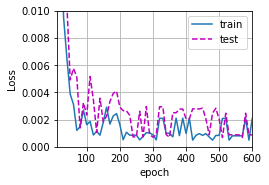

In [24]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs],ylim=[0, 0.01])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = SuportFunction.train_epoch(
        net, trainIter, lossFunc, trainer, False)
    testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
    if (epoch + 1) % 10 == 0:
        print(predict(preX))
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [25]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))



X= tensor([[ 0.3186,  0.6023,  0.5877,  0.6972,  0.4958],
        [ 0.7188,  0.2191,  1.1484, -0.7807,  0.4913],
        [ 0.7832,  0.3035,  1.1060, -0.6214,  0.7912],
        [-0.5884,  0.8441, -0.1741,  1.2108, -1.1047]])
Prediction= tensor([ 0.9791,  0.3342,  0.1750,  0.3702,  0.6612,  1.2100,  1.1960, -0.2701,
         0.7170, -0.7930, -0.6388,  1.2043,  0.5146,  0.5007,  0.8132, -1.0813,
         0.8841,  0.4474, -0.0637, -0.3728])
Y= tensor([ 0.6023,  0.2191,  0.3035,  0.8441,  0.5877,  1.1484,  1.1060, -0.1741,
         0.6972, -0.7807, -0.6214,  1.2108,  0.4958,  0.4913,  0.7912, -1.1047,
         0.8650,  0.4279, -0.0627, -0.3453])


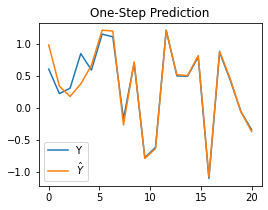

In [26]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [39]:
prefixSize=20
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [40]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [41]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

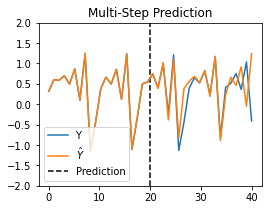

In [42]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();